In [25]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
data_full = pd.read_csv('C:\\Study\\Kaggle-MegaFon-MGTU\\contest_train_binary.csv')
target = data_full.copy()['TARGET']
id = data_full.copy()['ID']
data = data_full.copy()
del data['TARGET']
del data['ID']
#print(target)
print(data)

       FEATURE_0  FEATURE_1  FEATURE_2  FEATURE_3  FEATURE_4  FEATURE_5  \
0            2.0        2.0        0.0        0.0        0.0        0.0   
1            1.0        1.0        0.0        0.0        1.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            1.0        1.0        0.0        0.0        0.0        0.0   
4            4.0        3.0        1.0        0.0        1.0        0.0   
...          ...        ...        ...        ...        ...        ...   
24516        7.0        2.0        0.0        0.0        0.0        0.0   
24517        1.0        1.0        0.0        0.0        0.0        0.0   
24518        0.0        0.0        0.0        0.0        0.0        0.0   
24519        3.0        2.0        0.0        0.0        0.0        0.0   
24520        2.0        2.0        0.0        0.0        0.0        0.0   

       FEATURE_6   FEATURE_7  FEATURE_8  FEATURE_9  ...  FEATURE_250  \
0            0.0 -114.52781

In [3]:
# Для удобства имена всех фичей
temp = []
for i in data.columns:
    temp.append(i)
    #print(i)
names = pd.Series(temp, index=temp)
print(names)

FEATURE_0        FEATURE_0
FEATURE_1        FEATURE_1
FEATURE_2        FEATURE_2
FEATURE_3        FEATURE_3
FEATURE_4        FEATURE_4
                  ...     
FEATURE_255    FEATURE_255
FEATURE_256    FEATURE_256
FEATURE_257    FEATURE_257
FEATURE_258    FEATURE_258
FEATURE_259    FEATURE_259
Length: 260, dtype: object


In [4]:
# Неплохо бы глянуть распределение таргета
# Имеем неровную выборочку
print(pd.value_counts(target))

0    18871
1     5650
Name: TARGET, dtype: int64


In [5]:
# Корреляции? Корреляции
corrMatrix = data_full.corr()
#corrMatrix.to_csv(r'C:\Учеба\Kaggle-MegaFon-MGTU\corrMatrix.csv', index = False)
#corrMatrix = pd.read_csv(r'C:\Учеба\Kaggle-MegaFon-MGTU\corrMatrix.csv')
print(corrMatrix['TARGET'].sort_values(ascending=False))

TARGET         1.000000
FEATURE_203    0.142907
FEATURE_254    0.141381
FEATURE_206    0.138097
FEATURE_255    0.087746
                 ...   
FEATURE_196   -0.077949
FEATURE_3           NaN
FEATURE_144         NaN
FEATURE_249         NaN
FEATURE_256         NaN
Name: TARGET, Length: 262, dtype: float64


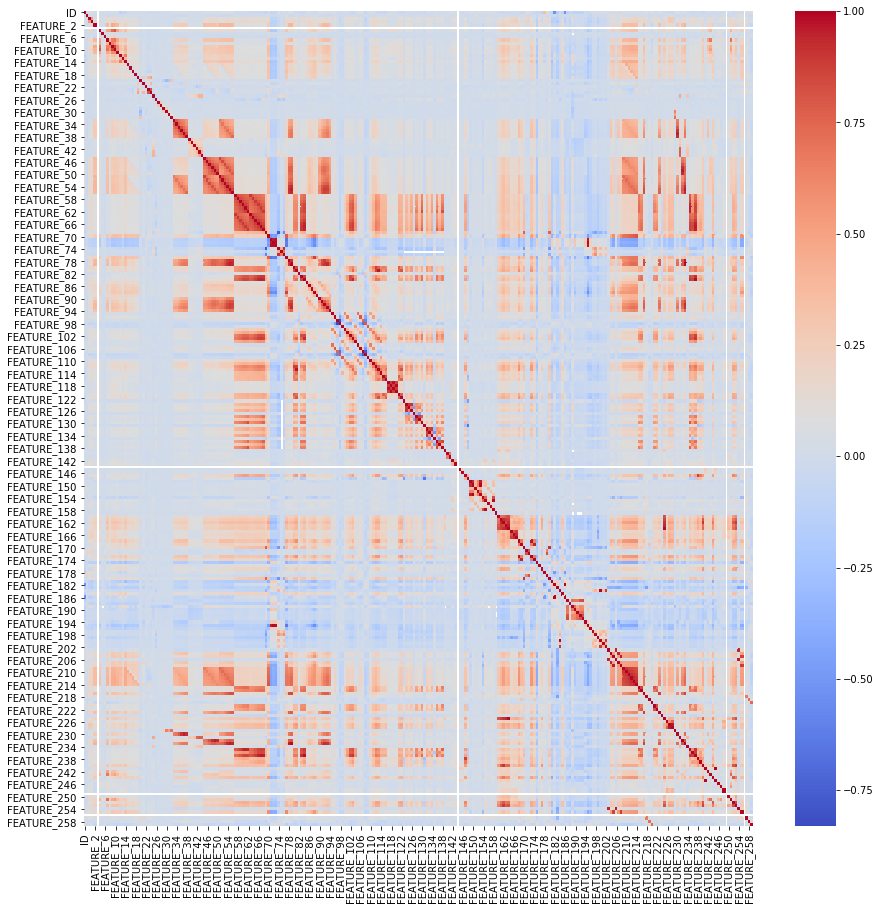

In [6]:
# Чего б и не нарисовать
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix,cmap='coolwarm')
plt.show()

In [7]:
# Смотрим, есть ли где-то признаки с пропусками
n_of_miss = data.isnull().sum()
is_miss = n_of_miss > 0
print(n_of_miss[is_miss].sort_values(ascending=False))


FEATURE_189    24196
FEATURE_194    17245
FEATURE_190    17192
FEATURE_191    15309
FEATURE_192    13060
FEATURE_193    12596
FEATURE_187    11878
FEATURE_71      2960
FEATURE_73      2960
FEATURE_195     2787
FEATURE_72      2781
FEATURE_153     2418
FEATURE_152     2418
FEATURE_151     2418
FEATURE_150     2418
FEATURE_149     2418
FEATURE_8       1144
FEATURE_188     1064
FEATURE_162      632
FEATURE_196      467
FEATURE_136      283
FEATURE_123      283
FEATURE_124      283
FEATURE_125      283
FEATURE_126      283
FEATURE_127      283
FEATURE_128      283
FEATURE_129      283
FEATURE_130      283
FEATURE_131      283
FEATURE_132      283
FEATURE_133      283
FEATURE_135      283
FEATURE_134      283
FEATURE_137      283
FEATURE_138      283
FEATURE_204      136
FEATURE_205      135
FEATURE_203      130
FEATURE_207      128
FEATURE_208      127
FEATURE_206      122
FEATURE_181      120
FEATURE_175      115
FEATURE_209       46
FEATURE_210       39
FEATURE_173       27
FEATURE_174  

486.0    1
61.0     1
124.0    1
359.0    1
406.0    1
        ..
63.0     3
1.0      3
154.0    3
118.0    3
142.0    4
Name: FEATURE_189, Length: 259, dtype: int64
       TARGET  FEATURE_189
322         0        261.0
718         1        119.0
719         1        181.0
1095        0        212.0
1485        0        371.0
...       ...          ...
23733       0        289.0
24122       0        573.0
24160       1          1.0
24389       0        319.0
24436       0        177.0

[325 rows x 2 columns]


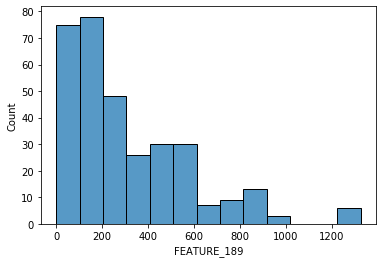

In [8]:
# Рассмотрим отдельно фичи, по которым больше всего пропусков
curr_name = 'FEATURE_189'
print(data_full[curr_name].value_counts().sort_values())
print(data_full[['TARGET', curr_name]][~data_full[curr_name].isnull()])
sn.histplot(data_full[curr_name]);

FEATURE_55     24521
FEATURE_63     24521
FEATURE_147    24521
FEATURE_79     24521
FEATURE_78     24521
               ...  
FEATURE_15         2
FEATURE_144        1
FEATURE_256        1
FEATURE_3          1
FEATURE_249        1
Length: 260, dtype: int64


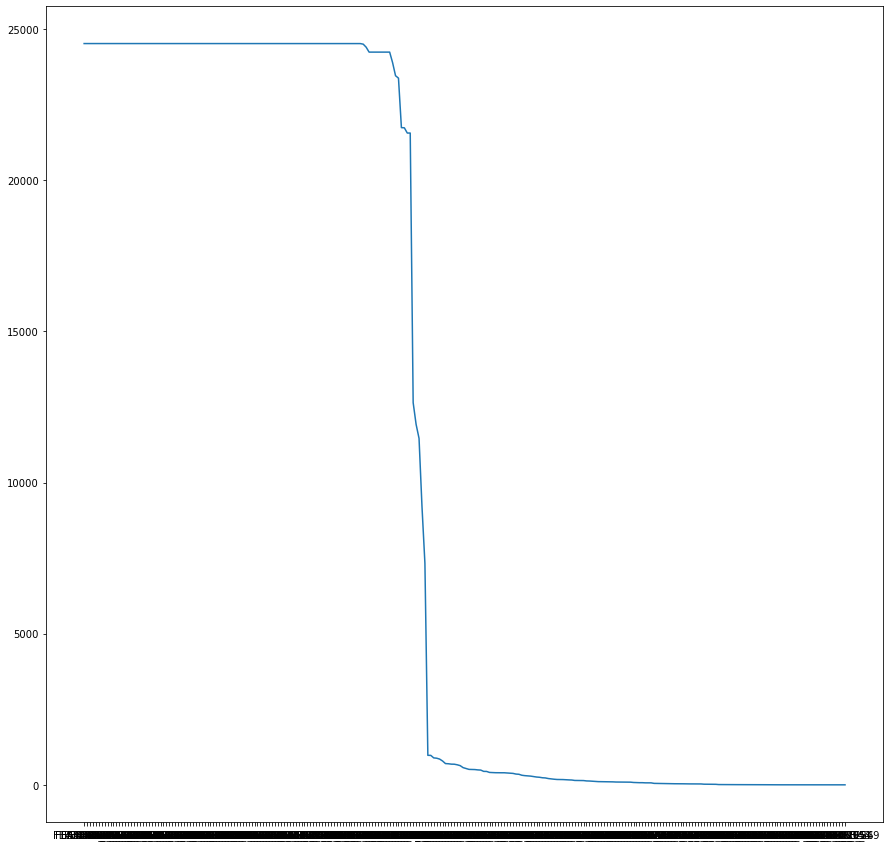

In [9]:
# Смотрим кол-ва уникальных значений всех признаков
# Ясно виден скачок, да
n_unique = data.nunique()
print(n_unique.sort_values(ascending=False))
#print(n_unique.sort_values()[30:90])

fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(n_unique.sort_values(ascending=False))
plt.show()

In [10]:
# Пороговое значение до скачка у нее
n_unique['FEATURE_196']

977

In [11]:
# Есть признаки, в которых вообще только одно уникальное значение
# И в них при этом нет миссингов, так что они реально бесполезные
useless_features = n_unique[n_unique < 2]
print(useless_features)


FEATURE_3      1
FEATURE_144    1
FEATURE_249    1
FEATURE_256    1
dtype: int64


In [12]:
# Смотрим, какие признаки бинарные
binary_features = n_unique[n_unique == 2]
print(binary_features)
binary_features_names = names[n_unique == 2]
#print(binary_features_names)

FEATURE_2      2
FEATURE_4      2
FEATURE_5      2
FEATURE_6      2
FEATURE_11     2
FEATURE_15     2
FEATURE_16     2
FEATURE_17     2
FEATURE_18     2
FEATURE_19     2
FEATURE_123    2
FEATURE_131    2
FEATURE_140    2
FEATURE_159    2
FEATURE_204    2
FEATURE_205    2
FEATURE_207    2
FEATURE_208    2
FEATURE_254    2
FEATURE_255    2
dtype: int64


In [13]:
# В каких бинарных есть миссинги
# Нужно будет заменить их
n_of_miss[n_unique == 2]

FEATURE_2        0
FEATURE_4        0
FEATURE_5        0
FEATURE_6        0
FEATURE_11       0
FEATURE_15       0
FEATURE_16       0
FEATURE_17       0
FEATURE_18       0
FEATURE_19       0
FEATURE_123    283
FEATURE_131    283
FEATURE_140      0
FEATURE_159      0
FEATURE_204    136
FEATURE_205    135
FEATURE_207    128
FEATURE_208    127
FEATURE_254      0
FEATURE_255      0
dtype: int64

In [43]:
# Точно числовыми будем считать те, где количество уникальных значений больше 1000
numerical_features_names = names[n_unique > 1000]
print(numerical_features_names.size)

117


In [41]:
# Неплохо бы глянуть распределение в признаках, где больше двух и не очень много значений
mb_categorial_names = names[(n_unique > 2) & (n_unique < 200)]
print(mb_categorial_names.size)
for name_i in mb_categorial_names:
    print('-------------------------')
    print(data[name_i].value_counts())

77
-------------------------
0.0      10612
1.0       3158
2.0       2023
3.0       1397
4.0       1101
         ...  
134.0        1
379.0        1
156.0        1
197.0        1
270.0        1
Name: FEATURE_0, Length: 160, dtype: int64
-------------------------
0.0     10612
1.0      5923
2.0      3451
3.0      1903
4.0      1103
5.0       648
6.0       376
7.0       202
8.0       116
9.0        76
10.0       50
12.0       19
11.0       16
13.0       10
14.0        7
19.0        2
17.0        2
31.0        1
15.0        1
39.0        1
18.0        1
30.0        1
Name: FEATURE_1, dtype: int64
-------------------------
0.0     19643
1.0      1846
2.0      1743
3.0      1141
4.0       124
5.0        14
7.0         4
11.0        2
8.0         2
6.0         2
Name: FEATURE_9, dtype: int64
-------------------------
0.0    19643
1.0     3942
2.0      787
3.0      128
4.0       14
5.0        7
Name: FEATURE_10, dtype: int64
-------------------------
0.0      6036
1.0      5714
2.0      3650


-------------------------
2.0    14219
1.0     9997
3.0      174
4.0        1
Name: FEATURE_203, dtype: int64
-------------------------
2.0    14490
1.0     9744
3.0      164
4.0        1
Name: FEATURE_206, dtype: int64
-------------------------
0.0    13889
3.0     3468
2.0     2531
1.0     2211
4.0     1406
5.0      538
6.0      432
Name: FEATURE_209, dtype: int64
-------------------------
0.0    13682
3.0     3419
2.0     2465
1.0     2276
4.0     1552
5.0      591
6.0      497
Name: FEATURE_210, dtype: int64
-------------------------
0.0    13498
3.0     3522
2.0     2515
1.0     2279
4.0     1512
5.0      652
6.0      526
Name: FEATURE_211, dtype: int64
-------------------------
0.0    13349
3.0     3633
2.0     2370
1.0     2155
4.0     1672
5.0      731
6.0      599
Name: FEATURE_212, dtype: int64
-------------------------
0.0    13227
3.0     3710
2.0     2381
1.0     2038
4.0     1718
5.0      780
6.0      663
Name: FEATURE_213, dtype: int64
-------------------------
0.0    13

In [50]:
# Подрежем данные - уберем пока все бинарные признаки и признаки с пропусками
# А еще лучше -- в которых количество уникальных меньше 1000
#cut_names = names[(n_unique > 2) & (n_unique < 1000) & (n_of_miss == 0)]

# Другая выборка -- все точно числовые, без пропусков
#cut_names = names[(n_unique > 1000) & (n_of_miss == 0)]

# Просто убираем все пропуски и бесполезные фичи
#cut_names = names[(n_unique > 1) & (n_of_miss == 0)]

# Только убираем бесполезные признаки
cut_names = names[(n_unique > 1)]

data_cut = data.copy()[cut_names]
data_cut

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,...,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,0.0,...,19.0,39.0,2.0,223.118594,290.015143,1.0,1.0,1.0,2.0,2.0
1,1.0,1.0,0.0,1.0,0.0,0.0,329.828334,NaN,3.0,2.0,...,1.0,25.0,82.0,479.616045,611.651594,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,0.0,...,78.0,119.0,0.0,352.268014,564.573421,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,0.0,...,0.0,1.0,0.0,410.524985,421.653876,1.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,1.0,0.0,0.0,677.745861,NaN,3.0,2.0,...,0.0,21.0,0.0,439.171356,476.189288,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24516,7.0,2.0,0.0,0.0,0.0,0.0,-36.555841,-43.535029,0.0,0.0,...,2.0,35.0,0.0,439.424027,431.111705,0.0,0.0,1.0,1.0,1.0
24517,1.0,1.0,0.0,0.0,0.0,0.0,-8.589135,-10.308442,0.0,0.0,...,2.0,52.0,0.0,355.145856,410.288394,1.0,1.0,2.0,1.0,2.0
24518,0.0,0.0,0.0,0.0,0.0,0.0,64.095346,-0.591111,0.0,0.0,...,7.0,0.0,0.0,110.133312,115.087534,0.0,0.0,1.0,1.0,1.0
24519,3.0,2.0,0.0,0.0,0.0,0.0,-14.182606,10.981605,0.0,0.0,...,20.0,0.0,0.0,514.319183,583.248265,1.0,0.0,1.0,2.0,1.0


In [53]:
# Заменяем бинарные признаки самыми популярными
for name_i in binary_features_names:
    data_cut[name_i].fillna(value=np.nanmedian(data_cut[name_i]))
    
# А числовые - средним арифметическим
for name_i in numerical_features_names:
    data_cut[name_i].fillna(value=np.nanmean(data_cut[name_i]))
    
# А теперь убираем очень большое число пропусков
data_cut = data_cut[names[(n_unique > 1) & (n_of_miss < 10000)]]

data_cut

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,...,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,0.0,...,19.0,39.0,2.0,223.118594,290.015143,1.0,1.0,1.0,2.0,2.0
1,1.0,1.0,0.0,1.0,0.0,0.0,329.828334,NaN,3.0,2.0,...,1.0,25.0,82.0,479.616045,611.651594,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,0.0,...,78.0,119.0,0.0,352.268014,564.573421,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,0.0,...,0.0,1.0,0.0,410.524985,421.653876,1.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,1.0,0.0,0.0,677.745861,NaN,3.0,2.0,...,0.0,21.0,0.0,439.171356,476.189288,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24516,7.0,2.0,0.0,0.0,0.0,0.0,-36.555841,-43.535029,0.0,0.0,...,2.0,35.0,0.0,439.424027,431.111705,0.0,0.0,1.0,1.0,1.0
24517,1.0,1.0,0.0,0.0,0.0,0.0,-8.589135,-10.308442,0.0,0.0,...,2.0,52.0,0.0,355.145856,410.288394,1.0,1.0,2.0,1.0,2.0
24518,0.0,0.0,0.0,0.0,0.0,0.0,64.095346,-0.591111,0.0,0.0,...,7.0,0.0,0.0,110.133312,115.087534,0.0,0.0,1.0,1.0,1.0
24519,3.0,2.0,0.0,0.0,0.0,0.0,-14.182606,10.981605,0.0,0.0,...,20.0,0.0,0.0,514.319183,583.248265,1.0,0.0,1.0,2.0,1.0


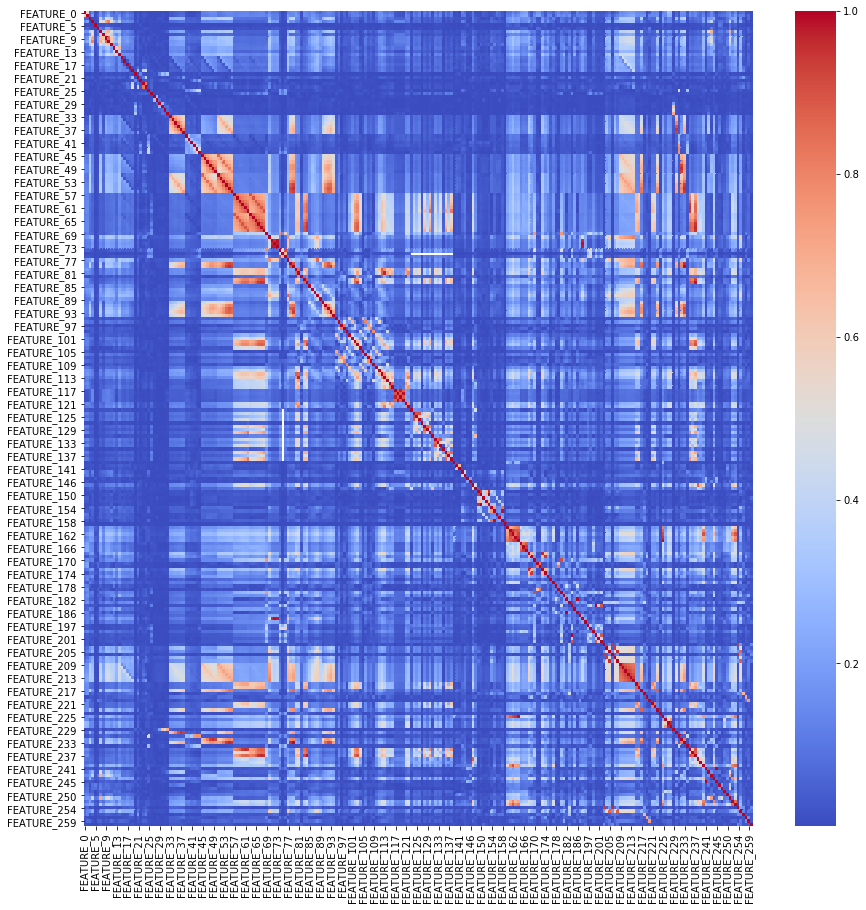

In [49]:
# Корреляции
temp = data_cut.copy()
temp['TARGET'] = target
corrMatrix_cut = temp.corr()
plt.figure(figsize=(15, 15))
sn.heatmap(np.abs(corrMatrix_cut),cmap='coolwarm')
plt.show()

FEATURE_107    24521
FEATURE_58     24521
FEATURE_108    24521
FEATURE_109    24521
FEATURE_112    24521
               ...  
FEATURE_6          2
FEATURE_5          2
FEATURE_4          2
FEATURE_2          2
FEATURE_159        2
Length: 203, dtype: int64


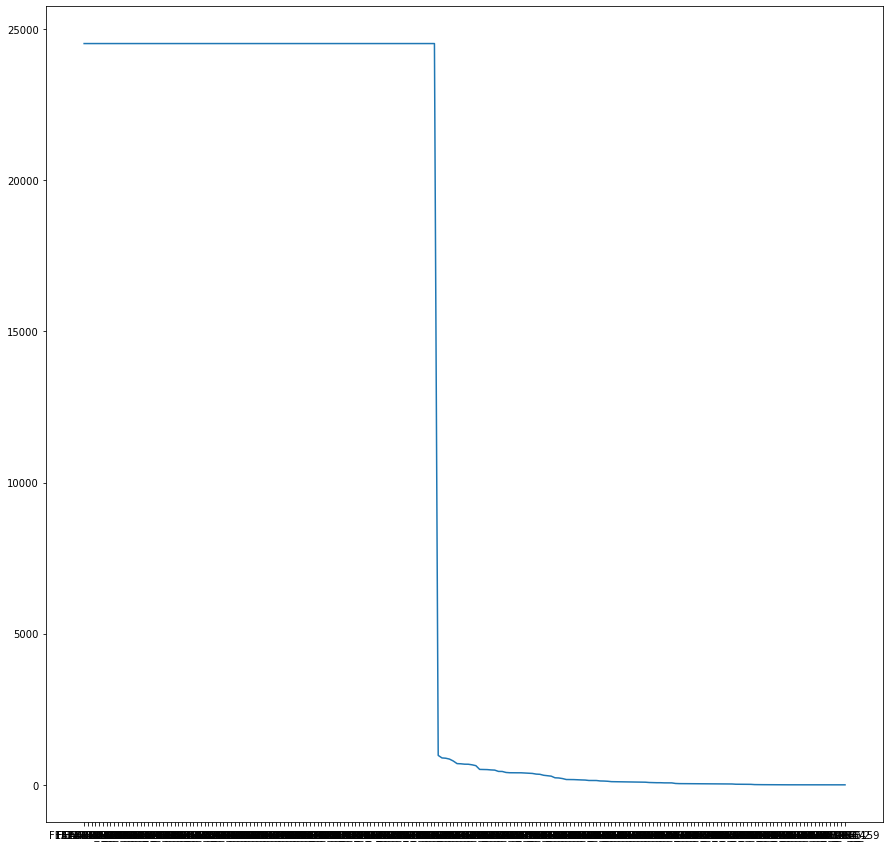

975


In [17]:
# Смотрим кол-ва уникальных значений всех признаков без миссингов
n_unique_cut = data_cut.nunique()
print(n_unique_cut.sort_values(ascending=False))
#print(n_unique.sort_values()[30:90])

fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(n_unique_cut.sort_values(ascending=False))
plt.show()
print(n_unique_cut['FEATURE_216'])

In [19]:
# А чего б и не обучить лесок на обрезанных данных
quality_data_list = []
for i in range(1, 11):
    classifier = RandomForestClassifier(random_state=42, n_estimators=i, n_jobs=3)
    validator = KFold(random_state=1, shuffle=True, n_splits=5)
    quality_cumm = []
    for train_indices, test_indices in validator.split(data_cut):
        # Делим выборку на обучающую и тестовую
        data_train = data_cut.iloc[train_indices]
        data_test = data_cut.iloc[test_indices]
        target_train = target[train_indices]
        target_test = target[test_indices]
        # Обучаемся
        classifier.fit(data_train, target_train)
        # Предсказываем
        target_pred = classifier.predict(data_test)
        # ROC-AUC
        quality_curr = roc_auc_score(target_test, target_pred)
        quality_cumm.append(quality_curr)
    # Усредняем качество по пяти тестам
    quality_data_list.append([i, np.average(quality_cumm)])
    print([i, np.average(quality_cumm)])
# Выводим данные
quality_data = pd.DataFrame(quality_data_list, columns=['num of trees', 'ROC-AUC'])

[1, 0.5267369938575284]
[2, 0.5145914577951148]
[3, 0.5222727754393462]
[4, 0.509820786077714]
[5, 0.5218337233225914]
[6, 0.5115527957307217]
[7, 0.5189167906516172]
[8, 0.5110953616152449]
[9, 0.5178970935614895]
[10, 0.5107843555916859]


In [21]:
classifier = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs=3)
data_train, data_test, target_train, target_test = train_test_split(data_cut, target, random_state=42)
# Обучаемся
classifier.fit(data_train, target_train)
# Предсказываем
target_pred = classifier.predict(data_test)
target_pred_prob = classifier.predict_proba(data_test)
# ROC-AUC
quality_curr = roc_auc_score(target_test, target_pred)
print(quality_curr)

0.5180248874480958


In [26]:
# А теперь AdaBoostClassifier
classifier = AdaBoostClassifier(random_state=42, n_estimators=10)
data_train, data_test, target_train, target_test = train_test_split(data_cut, target, random_state=42)
# Обучаемся
classifier.fit(data_train, target_train)
# Предсказываем
target_pred = classifier.predict(data_test)
target_pred_prob = classifier.predict_proba(data_test)
# ROC-AUC
quality_curr = roc_auc_score(target_test, target_pred)
print(quality_curr)

0.5


In [27]:
# Перцептрон?
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(random_state=42, alpha=1, max_iter=1000)
data_train, data_test, target_train, target_test = train_test_split(data_cut, target, random_state=42)
# Обучаемся
classifier.fit(data_train, target_train)
# Предсказываем
target_pred = classifier.predict(data_test)
target_pred_prob = classifier.predict_proba(data_test)
# ROC-AUC
quality_curr = roc_auc_score(target_test, target_pred)
print(quality_curr)


0.5148729517241878


In [31]:
# Байес?
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
data_train, data_test, target_train, target_test = train_test_split(data_cut, target, random_state=42)
# Обучаемся
classifier.fit(data_train, target_train)
# Предсказываем
target_pred = classifier.predict(data_test)
target_pred_prob = classifier.predict_proba(data_test)
# ROC-AUC
quality_curr = roc_auc_score(target_test, target_pred)
print(quality_curr)


0.5117969953194328


In [32]:
# Логистическая регрессия?
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)
data_train, data_test, target_train, target_test = train_test_split(data_cut, target, random_state=42)
# Обучаемся
classifier.fit(data_train, target_train)
# Предсказываем
target_pred = classifier.predict(data_test)
target_pred_prob = classifier.predict_proba(data_test)
# ROC-AUC
quality_curr = roc_auc_score(target_test, target_pred)
print(quality_curr)

0.5012647390834001


c:\users\sadbattlecruiser\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
